In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

定义transform，表明图片的处理方式和batch_size

In [3]:
# 如果内存不够的话，可以减小batch_size
# 一般batch_size越大，模型越稳定，训练速度越快。（但也不是越大越好）
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor(),# 将图片转为Tensor类型
      # 对图片进行正则化。第一个参数为mean(均值)，第二个为std(方差)。每个参数之所以有三个0.5，是因为有RGB三个通道。
     # 综上，这句就是把图片的RGB三个通道都正则化到均值为0.5，方差为0.5的分布上。
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:36<00:00, 4636313.33it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def imshow(img):
    # 之前进行了正则化，现在需要反正化回来
    img = img / 2 + 0.5
    # 转化为numopy.ndarray格式，plt不认识tensor
    npimg = img.numpy()
    # plt.imshow接受的图片shape为(c, h, w)
    # 即通道在最后一维，而传过来的img是(h, w, c)
    # 所以要用transpose改一下
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

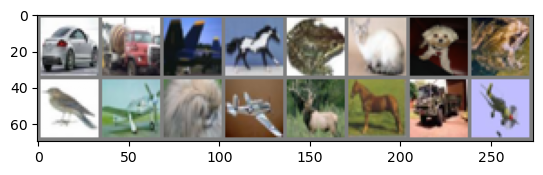

car   truck plane horse frog  cat   dog   frog  bird  plane dog   plane deer  horse truck plane


In [8]:
# 获取一些图片及对应标签
dataiter = iter(trainloader)
"""
这里images是一个tensor，shape为(16, 3, 32, 32)
	其中16为batch_size，即16张图片，3为RGB通道，图片大小为32x32
labels也是tensor，shape为(16)，为每个图片的对应的标签。
"""
images, labels = dataiter.__next__()
"""
make_grid：制作表格。即把多张图片拼到一张中去。
		   nrow=8，表示生成表格的列数。
从下面的输出可以看到，images的16张图片被make_grid
按照2x8的表格拼成了一张大图片。该方法方便人们进行
图像展示。
"""
imshow(torchvision.utils.make_grid(images, nrow = 8))
print((' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size))))

# 定义CNN分类模型

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        '''
        nn.Conv2d包含几个重要参数
            in_channels: 输入的通道数
            out_channels: 输出的通道数
            kernel_size: 卷积核的大小
            stride: 步长，默认为1
            padding: 填充，默认为0，即不进行填充
        '''
        self.classifier = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            # 使用MaxPool进行下采样。
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
             # 当完成卷积后，使用flatten将数据展开
            # 即将tensor的shape从(batch_size, c, h, w)变成(batch_size, c*h*w)，这样才能送给全连接层
            nn.Flatten(),
            
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
            # 注意这里并没有调用Softmax，也不能调Softmax
            # 这是因为Softmax被包含在了CrossEntropyLoss损失函数中
            # 如果这里调用的话，就会调用两遍，最后网络啥都学不着
        ) 
    def forward(self, x):
        return self.classifier(x)

In [10]:
net = Net()
# 使用简单的CrossEntorpyLoss作为损失函数，一般多分类问题都用这个
criterion = nn.CrossEntropyLoss()
# 使用简单的SGD作为优化器
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 训练网络

In [11]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.221
[2,  2000] loss: 1.609
[3,  2000] loss: 1.413
[4,  2000] loss: 1.292
[5,  2000] loss: 1.205
[6,  2000] loss: 1.140
[7,  2000] loss: 1.079
[8,  2000] loss: 1.031
[9,  2000] loss: 0.983
[10,  2000] loss: 0.940
[11,  2000] loss: 0.907
[12,  2000] loss: 0.873
[13,  2000] loss: 0.839
[14,  2000] loss: 0.811
[15,  2000] loss: 0.777
[16,  2000] loss: 0.754
[17,  2000] loss: 0.726
[18,  2000] loss: 0.701
[19,  2000] loss: 0.684
[20,  2000] loss: 0.655
Finished Training


# 测试模型

In [14]:
correct = 0 # 记录正确的数量
total = 0 # 记录总数

# torch.no_grad表示不需要计算梯度。
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        """
		outputs.shape为(16, 10)，batch_size为16, 10为类别
		output这16张图片的各个类别的可能性（未经Softmax处理）
		所以通过torch.max找到最大的那个。
		torch.max接受两个参数，第一个是tensor，第二个是dim（维度）
				 这里传1，意思是在类别这个维度上取最大的
		torch.max有两个输出，values和indexes，
				 values就是最大的数是什么，
				 indexes是这些最大的数的index是什么
		这里我们只需要index即可，所以忽略第一个参数
		"""
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 66.46%


计算每个类别的精确率

In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.7 %
Accuracy for class: car   is 76.7 %
Accuracy for class: bird  is 55.3 %
Accuracy for class: cat   is 53.0 %
Accuracy for class: deer  is 57.4 %
Accuracy for class: dog   is 55.0 %
Accuracy for class: frog  is 73.5 %
Accuracy for class: horse is 71.1 %
Accuracy for class: ship  is 78.5 %
Accuracy for class: truck is 78.4 %
